In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import glob
import os
from google.colab import drive


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Set your data path
DATA_PATH = "/content/drive/MyDrive/HUPA-UCM Diabetes Dataset (1)/HUPA-UCM Diabetes Dataset/Preprocessed"

# Check all files in the directory
import os
all_files = os.listdir(DATA_PATH)
print("All files in directory:")
for f in all_files:
    print(f" - {f}")

# Filter for CSV files
csv_files = [f for f in all_files if f.endswith('.csv')]
print(f"\nFound {len(csv_files)} CSV files:")
for f in csv_files:
    print(f" - {f}")


Mounted at /content/drive
All files in directory:
 - HUPA0006P.csv
 - HUPA0007P.csv
 - HUPA0009P.csv
 - HUPA0004P.csv
 - HUPA0017P.csv
 - HUPA0011P.csv
 - HUPA0001P.csv
 - HUPA0002P.csv
 - HUPA0003P.csv
 - HUPA0014P.csv
 - HUPA0005P.csv
 - HUPA0010P.csv
 - HUPA0015P.csv
 - HUPA0016P.csv
 - HUPA0025P.csv
 - HUPA0019P.csv
 - HUPA0021P.csv
 - HUPA0018P.csv
 - HUPA0023P.csv
 - HUPA0020P.csv
 - HUPA0024P.csv
 - HUPA0022P.csv
 - HUPA0028P.csv
 - HUPA0026P.csv
 - HUPA0027P.csv

Found 25 CSV files:
 - HUPA0006P.csv
 - HUPA0007P.csv
 - HUPA0009P.csv
 - HUPA0004P.csv
 - HUPA0017P.csv
 - HUPA0011P.csv
 - HUPA0001P.csv
 - HUPA0002P.csv
 - HUPA0003P.csv
 - HUPA0014P.csv
 - HUPA0005P.csv
 - HUPA0010P.csv
 - HUPA0015P.csv
 - HUPA0016P.csv
 - HUPA0025P.csv
 - HUPA0019P.csv
 - HUPA0021P.csv
 - HUPA0018P.csv
 - HUPA0023P.csv
 - HUPA0020P.csv
 - HUPA0024P.csv
 - HUPA0022P.csv
 - HUPA0028P.csv
 - HUPA0026P.csv
 - HUPA0027P.csv


In [ ]:
def load_all_patients_data(data_path, csv_files):

    patients_data = {}

    for filename in csv_files:
        try:
            filepath = os.path.join(data_path, filename)

            # Extract patient number from filename
            patient_num_str = filename.replace('HUPA', '').replace('P.csv', '').replace('.csv', '').lstrip('0')
            patient_num = int(patient_num_str) if patient_num_str else 1

            # Load with proper semicolon separation
            df = pd.read_csv(filepath, sep=';')


            # Convert time column to datetime
            df['time'] = pd.to_datetime(df['time'], errors='coerce')

            # Drop rows with invalid time
            df = df.dropna(subset=['time'])

            # Sort by time
            df = df.sort_values('time').reset_index(drop=True)

            # Convert numeric columns to appropriate types
            numeric_columns = ['glucose', 'calories', 'heart_rate', 'steps',
                             'basal_rate', 'bolus_volume_delivered', 'carb_input']

            for col in numeric_columns:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')

            patients_data[patient_num] = df

        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
            continue

    print(f"\nSuccessfully loaded {len(patients_data)} patients")
    return patients_data

# Load all patient data with proper semicolon separation
all_patients = load_all_patients_data(DATA_PATH, csv_files)


Successfully loaded 25 patients


In [ ]:
if all_patients:
    first_patient_id = list(all_patients.keys())[0]
    first_patient_data = all_patients[first_patient_id]

    print("First patient data shape:", first_patient_data.shape)
    print("\nColumns:", first_patient_data.columns.tolist())
    print("\nFirst few rows:")
    display(first_patient_data.head(10))

    # Data info
    print("\nData types:")
    print(first_patient_data.dtypes)

    # Check for missing values
    print("\nMissing values per column:")
    print(first_patient_data.isnull().sum())

    # Check time range and frequency
    print(f"\nTime range: {first_patient_data['time'].min()} to {first_patient_data['time'].max()}")
    time_diff = first_patient_data['time'].diff().mean()
    print(f"Average time difference: {time_diff}")

    # Basic statistics
    print("\nBasic statistics:")
    display(first_patient_data.describe())

else:
    print("No patients loaded. Let's debug the file structure...")

    # Debug: Check raw file content
    if csv_files:
        sample_file = os.path.join(DATA_PATH, csv_files[0])
        print(f"\nDebugging file: {csv_files[0]}")

        # Read raw file content
        with open(sample_file, 'r') as f:
            lines = f.readlines()

        print("First 3 lines of raw file:")
        for i, line in enumerate(lines[:3]):
            print(f"Line {i}: {line.strip()}")

First patient data shape: (2290, 8)

Columns: ['time', 'glucose', 'calories', 'heart_rate', 'steps', 'basal_rate', 'bolus_volume_delivered', 'carb_input']

First few rows:


,time,glucose,calories,heart_rate,steps,basal_rate,bolus_volume_delivered,carb_input
0,2018-07-09 15:45:00,109.000000,11.23939,70.769231,0.0,0.075000,0.0,0.0
1,2018-07-09 15:50:00,107.666667,8.11090,70.189655,5.0,0.075000,0.0,0.0
2,2018-07-09 15:55:00,106.333333,6.48872,70.170940,0.0,0.075000,0.0,0.0
3,2018-07-09 16:00:00,105.000000,7.06807,72.368421,0.0,0.060833,0.0,0.0
4,2018-07-09 16:05:00,122.333333,9.61721,68.219298,6.0,0.060833,0.0,10.0
5,2018-07-09 16:10:00,139.666667,6.02524,63.922330,0.0,0.060833,0.0,0.0
6,2018-07-09 16:15:00,157.000000,8.45851,72.055118,0.0,0.060833,10.8,0.0
7,2018-07-09 16:20:00,169.666667,7.53155,79.885965,0.0,0.060833,0.0,0.0
8,2018-07-09 16:25:00,182.333333,8.45851,70.419847,8.0,0.060833,0.0,0.0
9,2018-07-09 16:30:00,195.000000,7.53155,66.983193,0.0,0.060833,0.0,0.0



Data types:
time                      datetime64[ns]
glucose                          float64
calories                         float64
heart_rate                       float64
steps                            float64
basal_rate                       float64
bolus_volume_delivered           float64
carb_input                       float64
dtype: object

Missing values per column:
time                      0
glucose                   0
calories                  0
heart_rate                0
steps                     0
basal_rate                0
bolus_volume_delivered    0
carb_input                0
dtype: int64

Time range: 2018-07-09 15:45:00 to 2018-07-17 14:30:00
Average time difference: 0 days 00:05:00

Basic statistics:


,time,glucose,calories,heart_rate,steps,basal_rate,bolus_volume_delivered,carb_input
count,2290,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000
mean,2018-07-13 15:07:30,165.204585,9.844447,65.619278,34.008297,0.075411,0.099039,0.097817
min,2018-07-09 15:45:00,42.000000,5.793500,41.423423,0.000000,0.000000,0.000000,0.000000
25%,2018-07-11 15:26:15,96.000000,5.793500,56.225838,0.000000,0.070417,0.000000,0.000000
50%,2018-07-13 15:07:30,146.000000,6.488720,62.965289,0.000000,0.075000,0.000000,0.000000
75%,2018-07-15 14:48:45,219.583333,10.544170,71.688546,18.000000,0.091667,0.000000,0.000000
max,2018-07-17 14:30:00,438.000000,61.874579,157.697674,626.000000,0.108333,10.800000,10.000000
std,NaN,84.736079,7.172734,14.345994,83.938115,0.018310,0.797489,0.813170


In [ ]:
if all_patients:
    print("Data Quality Summary:")


    for patient_id, data in list(all_patients.items())[:5]:  # Check first 5 patients
        print(f"\nPatient {patient_id}:")
        print(f"  Records: {len(data)}")
        print(f"  Time span: {data['time'].max() - data['time'].min()}")
        print(f"  Glucose range: {data['glucose'].min():.1f} - {data['glucose'].max():.1f}")
        print(f"  Missing values: {data.isnull().sum().sum()}")

        # Check if we have insulin delivery data
        if 'bolus_volume_delivered' in data.columns:
            bolus_records = data[data['bolus_volume_delivered'] > 0]
            print(f"  Bolus records: {len(bolus_records)}")

        if 'carb_input' in data.columns:
            carb_records = data[data['carb_input'] > 0]
            print(f"  Carb intake records: {len(carb_records)}")

Data Quality Summary:

Patient 6:
  Records: 2290
  Time span: 7 days 22:45:00
  Glucose range: 42.0 - 438.0
  Missing values: 0
  Bolus records: 46
  Carb intake records: 37

Patient 7:
  Records: 3857
  Time span: 13 days 09:20:00
  Glucose range: 40.0 - 385.0
  Missing values: 0
  Bolus records: 89
  Carb intake records: 82

Patient 9:
  Records: 3812
  Time span: 13 days 05:35:00
  Glucose range: 100.0 - 307.0
  Missing values: 0
  Bolus records: 66
  Carb intake records: 44

Patient 4:
  Records: 3184
  Time span: 11 days 01:15:00
  Glucose range: 40.0 - 411.0
  Missing values: 0
  Bolus records: 45
  Carb intake records: 20

Patient 17:
  Records: 3599
  Time span: 12 days 11:50:00
  Glucose range: 40.0 - 401.0
  Missing values: 0
  Bolus records: 25
  Carb intake records: 35


In [ ]:
import pandas as pd

df_check = pd.read_csv("/content/drive/MyDrive/HUPA-UCM Diabetes Dataset (1)/HUPA-UCM Diabetes Dataset/Preprocessed/HUPA0009P.csv")
print(df_check.columns)


Index(['time;glucose;calories;heart_rate;steps;basal_rate;bolus_volume_delivered;carb_input'], dtype='object')


In [ ]:
# Meals
meal_features = ["carb_input", "calories_cumulative", "bolus_volume_delivered", "basal_rate"]

# Activity
activity_features = ["steps", "steps_cumulative", "heart_rate"]

# Glucose dynamics
glucose_features = ["glucose", "glucose_change", "glucose_rolling_mean"]

# Circadian
circadian_features = ["sin_hour", "cos_hour"]

# Target insulin
insulin_features = ["insulin_need"]


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df_raw = pd.read_csv("/content/drive/MyDrive/HUPA-UCM Diabetes Dataset (1)/HUPA-UCM Diabetes Dataset/Preprocessed/HUPA0009P.csv", sep=';', parse_dates=["time"])

# 2. Preprocess
df = preprocess_patient_data(df_raw)
# Example: correlation between each category and insulin features
def category_insulin_correlation(df):
    categories = {
        "Meals": meal_features,
        "Activity": activity_features,
        "Glucose Dynamics": glucose_features,
        "Circadian": circadian_features
    }

    # Build a DataFrame to store correlations
    corr_df = pd.DataFrame(index=categories.keys(), columns=insulin_features)

    for cat_name, cat_feats in categories.items():
        for insulin_feat in insulin_features:
            # Take mean correlation of all features in the category with the insulin feature
            corr_values = df[cat_feats + [insulin_feat]].corr()[insulin_feat][cat_feats]
            corr_df.loc[cat_name, insulin_feat] = corr_values.mean()

    return corr_df.astype(float)

corr_matrix = category_insulin_correlation(df)


/tmp/ipython-input-190456842.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=insulin_counts.index, y=insulin_counts.values, palette='viridis')


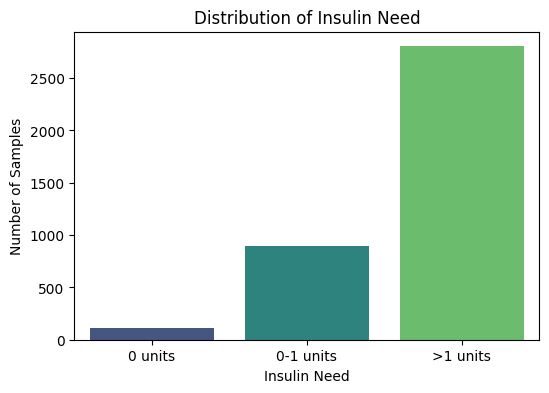

In [ ]:
# Categorize insulin need
bins = [-0.01, 0.01, 1, df['insulin_need'].max()]
labels = ['0 units', '0-1 units', '>1 units']
df['insulin_category'] = pd.cut(df['insulin_need'], bins=bins, labels=labels)

# Count per category
insulin_counts = df['insulin_category'].value_counts().sort_index()

plt.figure(figsize=(6,4))
sns.barplot(x=insulin_counts.index, y=insulin_counts.values, palette='viridis')
plt.ylabel("Number of Samples")
plt.xlabel("Insulin Need")
plt.title("Distribution of Insulin Need")
plt.show()


In [ ]:
def create_sequences_for_patient(patient_data, sequence_length=6):
    """
    Create sequences for a single patient
    """
    # Selected features for the model
    features = [
        'glucose', 'calories', 'heart_rate', 'steps',
        'basal_rate', 'bolus_volume_delivered', 'carb_input',
        'glucose_change', 'glucose_rolling_mean',
        'calories_cumulative', 'steps_cumulative',
        'sin_hour', 'cos_hour'
    ]

    # Only use features that exist in the dataframe
    available_features = [f for f in features if f in patient_data.columns]

    X, y = [], []

    for i in range(len(patient_data) - sequence_length):
        # Input sequence (last 30 minutes = 6 time steps * 5min)
        sequence_features = patient_data[available_features].iloc[i:i+sequence_length].values
        X.append(sequence_features)

        # Target: Insulin need in next period (after the sequence)
        target = patient_data['target_insulin_need'].iloc[i+sequence_length-1]
        y.append(target)

    return np.array(X), np.array(y)

In [ ]:
# New empty lists for final scaled data
X_train_scaled = []
y_train_log_scaled = []

X_val_scaled = []
y_val_log_scaled = []

X_test_scaled = []
y_test_log_scaled = []

# Unpack splits
train_ids, val_ids, test_ids = patient_splits

for patient_id, patient_data in all_patients.items():

    # preprocess raw data
    processed_data = preprocess_patient_data(patient_data)

    # create sequences
    X_patient, y_patient = create_sequences_for_patient(processed_data, sequence_length=6)

    # ---- PER-PATIENT SCALING ----
    scaler = StandardScaler()
    X_patient_2D = X_patient.reshape(-1, X_patient.shape[2])   # flatten time
    X_patient_scaled = scaler.fit_transform(X_patient_2D)
    X_patient_scaled = X_patient_scaled.reshape(X_patient.shape)

    # log-transform (optional)
    y_patient_log = np.log1p(y_patient)

    # ---- Assign to correct dataset ----
    if patient_id in train_ids:
        X_train_scaled.append(X_patient_scaled)
        y_train_log_scaled.append(y_patient_log)

    elif patient_id in val_ids:
        X_val_scaled.append(X_patient_scaled)
        y_val_log_scaled.append(y_patient_log)

    else:
        X_test_scaled.append(X_patient_scaled)
        y_test_log_scaled.append(y_patient_log)

# ---- CONCATENATE ----
X_train_final = np.concatenate(X_train_scaled)
y_train_final = np.concatenate(y_train_log_scaled)

X_val_final = np.concatenate(X_val_scaled)
y_val_final = np.concatenate(y_val_log_scaled)

X_test_final = np.concatenate(X_test_scaled)
y_test_final = np.concatenate(y_test_log_scaled)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    GRU, Dense, Dropout, BatchNormalization, LeakyReLU,
    Bidirectional, Attention, Input, Flatten
)
import tensorflow as tf

def create_insulin_gru_advanced(sequence_length=24, n_features=13):

    inputs = Input(shape=(sequence_length, n_features))

    # ----------------------------------------
    # 1) Bidirectional GRU Layer
    # ----------------------------------------
    x = Bidirectional(
        GRU(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.1)
    )(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # ----------------------------------------
    # 2) Stacked GRU Layer
    # ----------------------------------------
    x = GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.1)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # ----------------------------------------
    # 3) GRU Bottleneck
    # ----------------------------------------
    x = GRU(32, return_sequences=True, dropout=0.1)(x)

    # ----------------------------------------
    # 4) Attention Layer
    # ----------------------------------------
    attention_context = Attention()([x, x])
    attention_context = Flatten()(attention_context)

    # ----------------------------------------
    # 5) Deep Dense Block
    # ----------------------------------------
    x = Dense(128, kernel_initializer="he_normal")(attention_context)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(64, kernel_initializer="he_normal")(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)

    x = Dense(32, activation="relu")(x)

    # ----------------------------------------
    # 6) Final Output
    # ----------------------------------------
    output = Dense(1, activation="linear", name="insulin_output")(x)

    model = Model(inputs, output)
    return model


In [ ]:
model = create_insulin_gru_advanced(sequence_length=24, n_features=n_features)
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 13)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 24, 256)   │    109,824 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 24, 256)   │      1,024 │ bidirectional[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 24, 64)    │     61,824 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 64)    │        256 │ gru_1[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 24, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 24, 32)    │      9,408 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 24, 32)    │          0 │ gru_2[0][0],      │
│ (Attention)         │                   │            │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 768)       │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     98,432 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128)       │          0 │ dense[0][0]       │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ leaky_re_lu[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 64)        │          0 │ dense_1[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ insulin_output      │ (None, 1)         │         33 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 291,649 (1.11 MB)

 Trainable params: 290,753 (1.11 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae', 'mape']
)


In [ ]:
# 1) Create the model
model = create_insulin_gru_advanced(sequence_length=6, n_features=n_features)

# 2) Compile
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae', 'mape']
)

# 3) Train (example with callbacks)
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/insulin_model/best_insulin_model.keras',
                                       monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=15,
    batch_size=32,
    callbacks=callbacks
)


# 4) Now the model is saved at '/content/drive/MyDrive/insulin_model/best_insulin_model.keras'


Epoch 1/15
9101/9101 ━━━━━━━━━━━━━━━━━━━━ 430s 46ms/step - loss: 0.1058 - mae: 0.2185 - mape: 47628672.0000 - val_loss: 0.0689 - val_mae: 0.2013 - val_mape: 40050948.0000
Epoch 2/15
9101/9101 ━━━━━━━━━━━━━━━━━━━━ 451s 47ms/step - loss: 0.0218 - mae: 0.1005 - mape: 16083819.0000 - val_loss: 0.0399 - val_mae: 0.1510 - val_mape: 30726150.0000
Epoch 3/15
9101/9101 ━━━━━━━━━━━━━━━━━━━━ 441s 46ms/step - loss: 0.0159 - mae: 0.0825 - mape: 12436284.0000 - val_loss: 0.0412 - val_mae: 0.1562 - val_mape: 26692258.0000
Epoch 4/15
9101/9101 ━━━━━━━━━━━━━━━━━━━━ 419s 46ms/step - loss: 0.0136 - mae: 0.0740 - mape: 10308484.0000 - val_loss: 0.0413 - val_mae: 0.1536 - val_mape: 27350996.0000
Epoch 5/15
9101/9101 ━━━━━━━━━━━━━━━━━━━━ 450s 47ms/step - loss: 0.0121 - mae: 0.0679 - mape: 8618122.0000 - val_loss: 0.0378 - val_mae: 0.1484 - val_mape: 29543026.0000
Epoch 6/15
9101/9101 ━━━━━━━━━━━━━━━━━━━━ 424s 47ms/step - loss: 0.0111 - mae: 0.0639 - mape: 7745727.5000 - val_loss: 0.0358 - val_mae: 0.1438 - 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from tensorflow.keras.models import load_model

save_path = '/content/drive/MyDrive/insulin_model/best_insulin_model.keras'

# Load the saved model
model = load_model(save_path)
print("✅ Model loaded successfully!")
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        min_delta=1e-4,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=save_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=15,  # total additional epochs you want to run
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model loaded successfully!
Epoch 1/15
5615/9101 ━━━━━━━━━━━━━━━━━━━━ 2:38 46ms/step - loss: 0.3648 - mae: 0.4083 - mape: 86898944.0000

KeyboardInterrupt: 

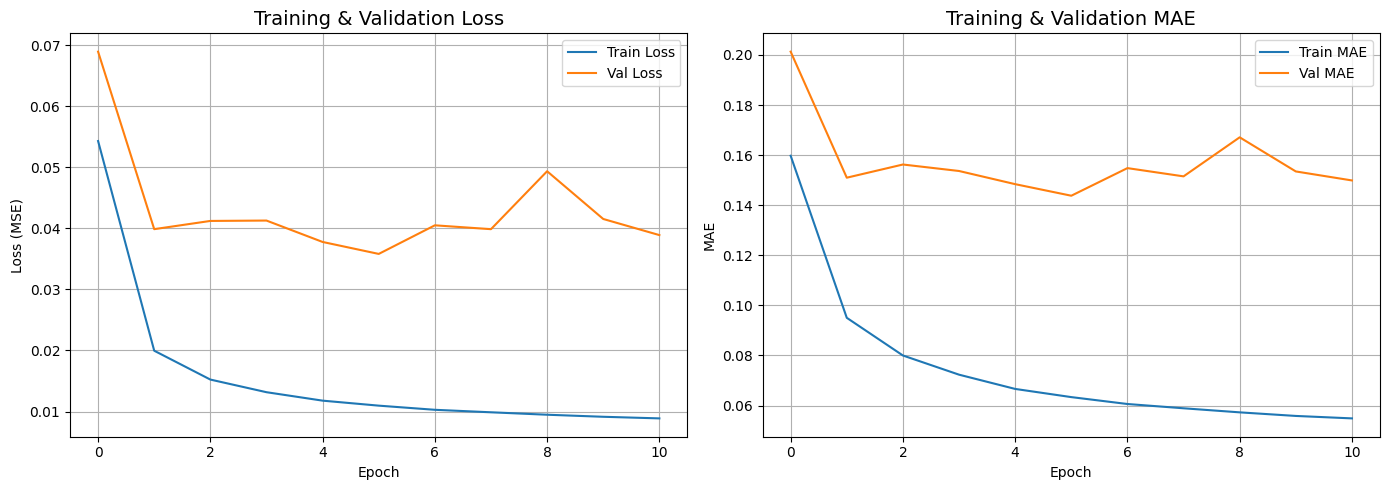

NameError: name 'y_pred' is not defined

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Training & Validation Curves
# -----------------------------
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(14,5))

    # Loss
    ax[0].plot(history.history['loss'], label='Train Loss')
    ax[0].plot(history.history['val_loss'], label='Val Loss')
    ax[0].set_title('Training & Validation Loss', fontsize=14)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss (MSE)')
    ax[0].legend()
    ax[0].grid(True)

    # MAE
    if 'mae' in history.history:
        ax[1].plot(history.history['mae'], label='Train MAE')
        ax[1].plot(history.history['val_mae'], label='Val MAE')
        ax[1].set_title('Training & Validation MAE', fontsize=14)
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('MAE')
        ax[1].legend()
        ax[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# -----------------------------
# 2. Predictions vs True Insulin
# -----------------------------
def plot_predictions(y_true, y_pred, n_samples=500):
    plt.figure(figsize=(12,5))
    plt.plot(y_true[:n_samples], label='True Insulin', linewidth=2)
    plt.plot(y_pred[:n_samples], label='Predicted Insulin', linewidth=2)
    plt.title('Insulin Prediction vs True Values (Sample Window)', fontsize=14)
    plt.xlabel('Time Steps')
    plt.ylabel('Insulin Need (units)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_predictions(y_test, y_pred)

# Scatter plot: y_true vs y_pred
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred.flatten(), alpha=0.3)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel('True Insulin Need')
plt.ylabel('Predicted Insulin Need')
plt.title('Predicted vs True Insulin Need', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 3. Residual Analysis
# -----------------------------
residuals = y_test - y_pred.flatten()

plt.figure(figsize=(10,5))
sns.histplot(residuals, bins=50, kde=True, color='skyblue')
plt.title('Residual Distribution (y_true - y_pred)', fontsize=14)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Residuals vs True Insulin
plt.figure(figsize=(10,5))
sns.scatterplot(x=y_test, y=residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs True Insulin Need', fontsize=14)
plt.xlabel('True Insulin Need')
plt.ylabel('Residual')
plt.grid(True)
plt.show()

# -----------------------------
# 4. Predicted vs True Distribution
# -----------------------------
plt.figure(figsize=(10,5))
sns.kdeplot(y_test, label='True Insulin', fill=True)
sns.kdeplot(y_pred.flatten(), label='Predicted Insulin', fill=True)
plt.title('Distribution of True vs Predicted Insulin', fontsize=14)
plt.xlabel('Insulin Need (units)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


Text(0.5, 1.0, 'Actual vs Predicted')

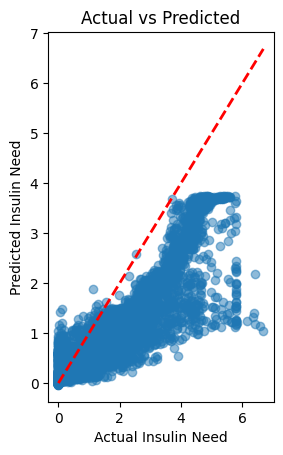

In [ ]:
# Scatter: actual vs predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Insulin Need')
plt.ylabel('Predicted Insulin Need')
plt.title('Actual vs Predicted')


In [ ]:
def permutation_importance(model, X_val, y_val, baseline_loss=None):
    n_features = X_val.shape[2]
    if baseline_loss is None:
        baseline_pred = model.predict(X_val, verbose=0)
        baseline_loss = mean_absolute_error(y_val, baseline_pred)

    importances = []

    for f in range(n_features):
        X_val_shuffled = X_val.copy()
        np.random.shuffle(X_val_shuffled[:, :, f])

        y_pred = model.predict(X_val_shuffled, verbose=0)
        loss = mean_absolute_error(y_val, y_pred)

        importances.append(loss - baseline_loss)

    return np.array(importances)


# Compute permutation importance
perm_importance = permutation_importance(model, X_val_final, y_val_final)

plt.bar(range(len(perm_importance)), perm_importance)
plt.xlabel("Feature index")
plt.ylabel("Importance (MAE increase)")
plt.title("Permutation Feature Importance")
plt.show()


KeyboardInterrupt: 

In [ ]:
# Use the original simple data preparation function
def prepare_all_patients_data(all_patients_data, sequence_length=6):

    # Patient IDs
    patient_ids = list(all_patients_data.keys())
    np.random.seed(42)
    np.random.shuffle(patient_ids)

    # Split patients (20 train, 3 val, 2 test for 25 patients)
    train_patients = patient_ids[:20]
    val_patients = patient_ids[20:23]
    test_patients = patient_ids[23:]

    print(f"Train patients: {train_patients}")
    print(f"Val patients: {val_patients}")
    print(f"Test patients: {test_patients}")

    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test, y_test = [], []

    # Process each patient
    for patient_id, patient_data in all_patients_data.items():
        # Preprocess patient data
        processed_data = preprocess_patient_data(patient_data)

        # Create sequences
        X_patient, y_patient = create_sequences_for_patient(processed_data, sequence_length)

        # Assign to appropriate split
        if patient_id in train_patients:
            X_train.append(X_patient)
            y_train.append(y_patient)
        elif patient_id in val_patients:
            X_val.append(X_patient)
            y_val.append(y_patient)
        else:  # test patients
            X_test.append(X_patient)
            y_test.append(y_patient)

    # Concatenate all sequences
    if X_train:
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
    if X_val:
        X_val = np.concatenate(X_val, axis=0)
        y_val = np.concatenate(y_val, axis=0)
    if X_test:
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)

    print(f"\nFinal dataset shapes:")
    print(f"Training set: {X_train.shape} sequences")
    print(f"Validation set: {X_val.shape} sequences")
    print(f"Test set: {X_test.shape} sequences")

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), (train_patients, val_patients, test_patients)

# Now prepare the data with the simple version

(X_train, y_train), (X_val, y_val), (X_test, y_test), patient_splits = prepare_all_patients_data(all_patients)

print(f"Data prepared!")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Get the number of features
n_features = X_train.shape[2]
print(f"Number of features: {n_features}")
X_train_scaled = []
y_train_log_scaled = []

for patient in patients:  # loop over patient datasets
    scaler = StandardScaler()
    X_patient = scaler.fit_transform(X_patient)  # fit per patient
    X_train_scaled.append(X_patient)

    y_patient_log = np.log1p(y_patient)  # optional, per patient
    y_train_log_scaled.append(y_patient_log)

# Then combine all patients back for model training
X_train_scaled = np.concatenate(X_train_scaled)
y_train_log_scaled = np.concatenate(y_train_log_scaled)
